# Deep Learning based Models for Solar Energy Prediction

## Import all the needed packages

In [1]:
# Basic Data Science Packages
import numpy as np
import pandas as pd

#TensorFlow packages for building DRNN layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Reshape, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential

#Plotting graph
import matplotlib.pyplot as plt

#Plotting Keras Model
from tensorflow.keras.utils import plot_model

#Normalization of data
from sklearn.preprocessing import StandardScaler

#Utility Module for computing and displaying metrics
from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [2]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

#Extracting dataset into train, validation and test sets
train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

scaler = StandardScaler()

#Extracting solar and wind X, y columns per set
X_solar_train = train[['SWTDN', 'SWGDN', 'T']]
y_solar_train = train['DE_solar_generation_actual']
X_solar_valid = valid[['SWTDN', 'SWGDN', 'T']]
y_solar_valid = valid['DE_solar_generation_actual']
X_solar_test = test[['SWTDN', 'SWGDN', 'T']]
y_solar_test = test['DE_solar_generation_actual']

X_wind_train = scaler.fit_transform(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = scaler.fit_transform(train['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_valid = scaler.fit_transform(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = scaler.fit_transform(valid['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_test = scaler.fit_transform(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = scaler.fit_transform(test['DE_wind_generation_actual'].values.reshape(-1,1))

## Building a DRNN Layer using Recurrent Neural Net with Fully Connected Layer

In [3]:
solar_model = Sequential()
#Mapping to the input size
solar_model.add(Input(shape=(3,)))
#Reshaping for the RNN Layer to perform
solar_model.add(Reshape((-1,1)))
#Creating RNN with 100 units and TanH Activation
solar_model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_solar_train.shape, return_sequences=False))
#Attaching a Dense Layer of the same unit size
solar_model.add(Dense(100))
#Batch Normalization on the output from the dense layer
solar_model.add(BatchNormalization())
#Extracting single output using Dense of 1
solar_model.add(Dense(1))
solar_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3, 1)              0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


## Compiling the model by passing adam optimizer, loss=MAE

In [4]:
solar_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history = solar_model.fit(X_solar_train, y_solar_train, epochs = 20, validation_data = (X_solar_valid, y_solar_valid))

Epoch 1/20
191/191 [==============================] - 13s 25ms/step - loss: 4679.1498 - val_loss: 3147.2004
Epoch 2/20
191/191 [==============================] - 2s 9ms/step - loss: 4583.8039 - val_loss: 3183.2922
Epoch 3/20
191/191 [==============================] - 2s 8ms/step - loss: 4643.5322 - val_loss: 3201.4600
Epoch 4/20
191/191 [==============================] - 2s 10ms/step - loss: 4673.5221 - val_loss: 3054.6423
Epoch 5/20
191/191 [==============================] - 1s 8ms/step - loss: 4527.0315 - val_loss: 3022.9739
Epoch 6/20
191/191 [==============================] - 1s 3ms/step - loss: 4422.3115 - val_loss: 2962.5879
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 4370.4576 - val_loss: 2916.9209
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 4421.9907 - val_loss: 2803.4773
Epoch 9/20
191/191 [==============================] - 1s 3ms/step - loss: 4246.9105 - val_loss: 2738.5837
Epoch 10/20
191/191 [======================

In [5]:
solar_model.evaluate(X_solar_test, y_solar_test)

41/41 [==============================] - 0s 1ms/step - loss: 552.2359


552.2359008789062

### Plotting Keras model

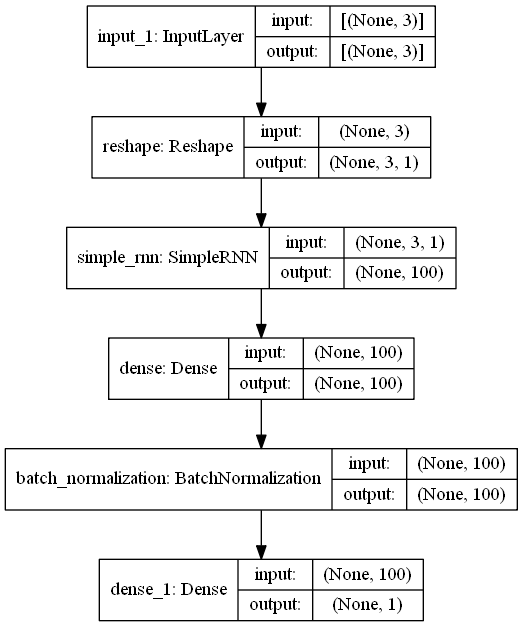

In [6]:
plot_model(
    solar_model, to_file='figs/5-model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Plotting Model's Loss Metrics over Train and Validation sets for Solar

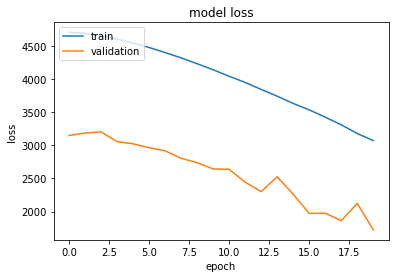

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predictions on the same plot

In [8]:
train_solar_pred = solar_model.predict(X_solar_train)
val_solar_pred = solar_model.predict(X_solar_valid)
test_solar_pred = solar_model.predict(X_solar_test)

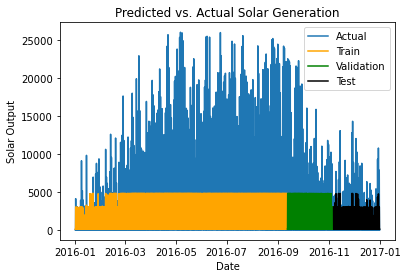

In [9]:
df = thesis_dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = train_solar_pred

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = val_solar_pred

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = test_solar_pred

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_solar_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_solar_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_solar_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

### Regression Metrics for Solar

In [10]:
metrics('drnn', test[['DE_solar_generation_actual']], test_solar_pred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,552.235825,1373.046971,37.054648,3.612394,0.660112


## Modelling and Fitting the model for Wind Dataset

In [11]:
wind_model = Sequential()
wind_model.add(Input(shape=(4,)))
wind_model.add(Reshape((-1,1)))
wind_model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_wind_train.shape, return_sequences=False))
wind_model.add(Dense(100))
wind_model.add(BatchNormalization())
wind_model.add(Dense(1))
wind_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 4, 1)              0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


In [12]:
wind_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = wind_model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=20)

Epoch 1/20
191/191 [==============================] - 2s 4ms/step - loss: 0.2767 - val_loss: 0.2980
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1144 - val_loss: 0.1661
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1174 - val_loss: 0.1290
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1030 - val_loss: 0.1250
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 0.0954 - val_loss: 0.1805
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1243 - val_loss: 0.1050
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1012 - val_loss: 0.0991
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1092 - val_loss: 0.1744
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 0.0923 - val_loss: 0.1322
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1089 - val_loss: 0.0902

In [13]:
wind_model.evaluate(X_wind_test, y_wind_test)

41/41 [==============================] - 0s 800us/step - loss: 0.0785


0.07854778319597244

## Model's Loss for Wind Dataset

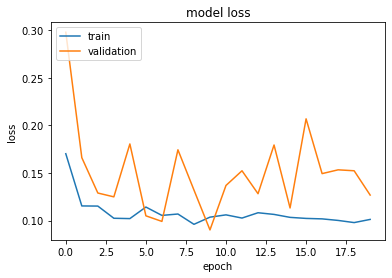

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predicted for Wind on same graph

In [15]:
train_wind_pred = wind_model.predict(X_wind_train)
val_wind_pred = wind_model.predict(X_wind_valid)
test_wind_pred = wind_model.predict(X_wind_test)

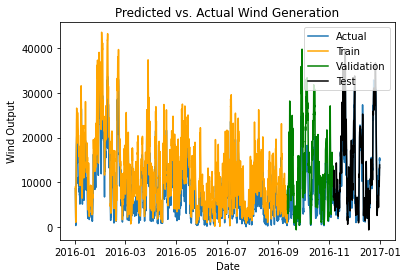

In [16]:
df = thesis_dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(train_wind_pred)

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(val_wind_pred)

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(test_wind_pred)

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_wind_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_wind_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_wind_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Wind Generation")
plt.show()

### Regression Metrics for Wind

In [17]:
metrics('drnn', test[['DE_wind_generation_actual']], scaler.inverse_transform(test_wind_pred))

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,1850.533282,2422.759498,49.221535,3.896331,0.921452
